In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 15
plt.style.use("ggplot")
mpl.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 12

titanic = sns.load_dataset('titanic')

## 결측치의 종류

1. MCAR ( Missing Completely At Random ) : 완전 무작위인 결측치

2. MAR ( Missing At Random ) : 임의적인 결측치

3. NI (Non-ignorable) : 무시할 수 없는 결측치

## 결측치 확인

In [3]:
titanic.isna().sum()
# isnull() 도 같은 기능

survived         0
pclass           0
sex              0
age            177
sibsp            0
              ... 
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
Length: 15, dtype: int64

In [7]:
# null이 아닌 값
titanic.notna().sum()
# notnull() 도 같은 기능

survived       891
pclass         891
sex            891
age            714
sibsp          891
              ... 
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
Length: 15, dtype: int64

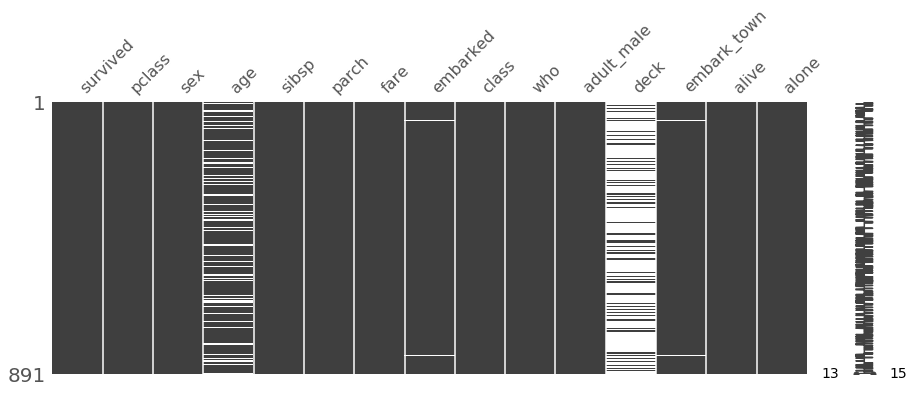

In [4]:
# missingno 모듈을 통해 시각화
import missingno as msno
msno.matrix(titanic, figsize=(15,5))

#### 참고 : 결측치에는 NaN, NAN, nan이 존재한다. 이 들은 값 자체가 없기 때문에 서로 다른 값으로 인식한다. (자기 자신도 포함)

In [5]:
from numpy import NaN, NAN, nan
print( 'NaN == NaN {} '.format(NaN == NaN), '|  NaN == NAN {} '.format(NaN == NAN), '|  NaN == nan {}'.format(NaN == nan) )

NaN == NaN False  |  NaN == NAN False  |  NaN == nan False


# 결측치를 처리하는 방법

## 1. 결측치를 제거하고 계산하기

### NA데이터가 MCAR이라는 가정이 있어야 한다??

#### listwise deletion : NA값이 포함된 모든 row를 제외하고 계산하는 방법

In [8]:
titanic.dropna(how='any').shape # row 중에 하나라도 nan이 존재하면 삭제
titanic.dropna(how='all').shape # row의 모든 값이 nan일 때 삭제

(891, 15)

#### pairwise deletion : 계산에 필요한 feature에서만 해당 row를 제외하고 계산하는 방법
    변수 선정에 따라 sample 수가 다를 수 있다.
    
    단점에 대한 이해가 필요
    

## 2. 결측치 대체값으로 채우기 ( Imputation )

17, 19, 26번 ROW가 NaN 값을 가지고 있다.

In [29]:
fill_df = titanic.loc[15:27,['age']]
fill_df

,age
15,55.0
16,2.0
17,NaN
18,31.0
19,NaN
20,35.0
21,34.0
22,15.0
23,28.0
24,8.0


### 1. 특정값으로 채우기 ( mean, median, mode ... )

In [30]:
fill_df.fillna(100) # 100으로 대체
fill_df.fillna(titanic['age'].mode()[0]) # mod(최빈값)으로 대체

,age
15,55.0
16,2.0
17,24.0
18,31.0
19,24.0
20,35.0
21,34.0
22,15.0
23,28.0
24,8.0


### 2. 앞 뒤 value의 관계를 활용하여 채우기 

In [31]:
fill_df.fillna(method='ffill') # 앞의 값으로 대체
# fill_df.fillna(method='bfill') # 뒤의 값으로 대체

,age
15,55.0
16,2.0
17,2.0
18,31.0
19,31.0
20,35.0
21,34.0
22,15.0
23,28.0
24,8.0


In [32]:
fill_df.interpolate(method='linear') # linear는 앞 뒤의 평균값으로 대체한다는 의미

,age
15,55.0
16,2.0
17,16.5
18,31.0
19,33.0
20,35.0
21,34.0
22,15.0
23,28.0
24,8.0


## nan값을 예측하여 채우기

### 1. Linear Regression으로 채우기

#### e.g. ) NaN으로 존재하는 Age feature의 value를  Linear regression으로 다른 feature를 활용하여 예측

In [36]:
fill_reg_df = titanic.loc[:,['fare', 'sibsp', 'parch', 'survived','age']]
fill_reg_df

,fare,sibsp,parch,survived,age
0,7.2500,1,0,0,22.0
1,71.2833,1,0,1,38.0
2,7.9250,0,0,1,26.0
3,53.1000,1,0,1,35.0
4,8.0500,0,0,0,35.0
...,...,...,...,...,...
886,13.0000,0,0,0,27.0
887,30.0000,0,0,1,19.0
888,23.4500,1,2,0,NaN
889,30.0000,0,0,1,26.0


In [45]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

train_X = fill_reg_df[fill_reg_df.age.notnull()].iloc[:,:4]
train_y = fill_reg_df[fill_reg_df.age.notnull()].age

reg_model= reg.fit(X=train_X,y=train_y)

test_X = fill_reg_df[fill_reg_df.age.isnull()].iloc[:,:4]
test_y = list(map(round, reg_model.predict(test_X)))
test_y[:10]

[33.0, 30.0, 29.0, 33.0, 29.0, 33.0, 32.0, 29.0, 29.0, 33.0]

In [84]:
# nan 데이터에 적용하기
titanic.loc[test_X.index,['age']] = test_y
titanic.loc[test_X.index,['age']]

,age
5,33.0
17,30.0
19,29.0
26,33.0
28,29.0
...,...
859,33.0
863,-5.0
868,33.0
878,33.0


### 2. predictive_imputer로  채우기

#### predictive_imputer 모듈은 R의 missforest 패키지를 파이썬으로 구현한 것이다.  ( missforest는 random forest를 활용하여 결측치를 예측 )

In [68]:
import predictive_imputer